In [1]:
import fastai_scans
from fastai.basics import *

In [2]:
voxels = (34, 42, 34)

In [3]:
brains_path = '../data/brains_IXI'
targets_path = '../data/targets.csv'
data = (fastai_scans.VolumeItemList.from_paths(Path(brains_path), Path(targets_path))
                                   .split_by_rand_pct(0.2, seed=7)
                                   .label_from_metadata('age_centuries')
                                   .transform(fastai_scans.get_transforms())
                                   .databunch(bs=32)
                                   .normalize())

/home/lfisch/.conda/envs/fastba/lib/python3.6/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


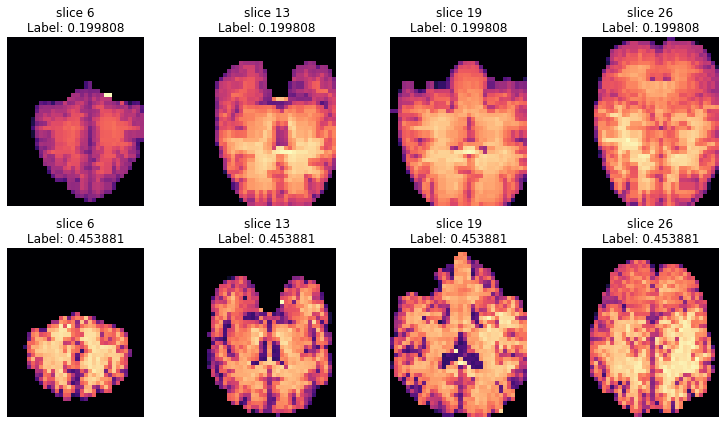

In [4]:
# Show data
data.show_batch(2)

In [5]:
model = fastai_scans.models.ResNet3d(voxels, num_blocks=[1], num_classes=1)
learn = Learner(data, model, metrics=[mean_absolute_error])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 3.63E-02


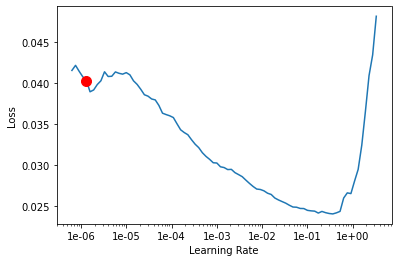

In [6]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [7]:
learn.fit_one_cycle(30, 1e-1)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.029319,0.212867,0.433790,00:00
1,0.022311,0.235722,0.461657,00:00
2,0.019519,0.153546,0.367835,00:00
3,0.018866,0.279048,0.499980,00:00
4,0.019327,0.020778,0.121959,00:00
5,0.018276,0.067293,0.232322,00:00
6,0.017785,0.018393,0.109356,00:00
7,0.016753,0.013576,0.093472,00:00
8,0.015753,0.019679,0.112618,00:00
9,0.014810,0.207454,0.433211,00:00


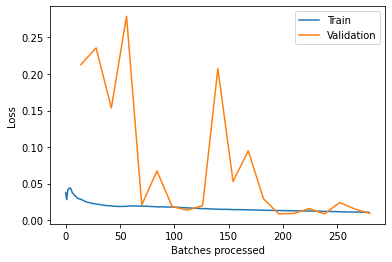

In [8]:
learn.recorder.plot_losses()

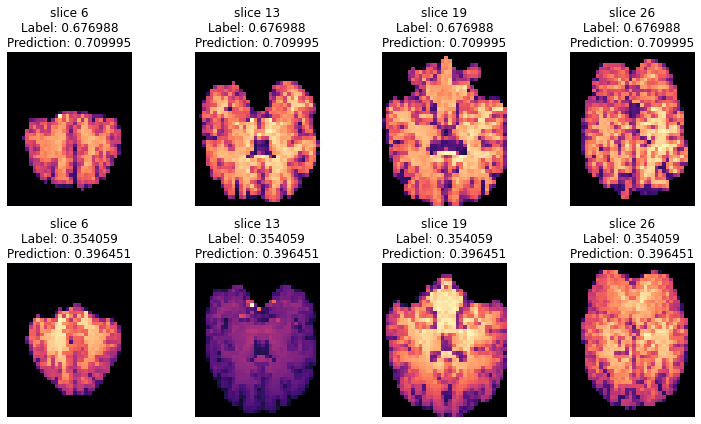

In [9]:
learn.show_results(rows=2)